In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import fasttext
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import torch.nn.functional as F
import torch

import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import norm
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

from tqdm import tqdm

import random

sns.set_theme()

# Set fixed random number seed
torch.manual_seed(42)

%matplotlib inline

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    return (accuracy_score(true_labels, predicted_labels),
           precision_score(true_labels, predicted_labels),
           recall_score(true_labels, predicted_labels))

def get_random_number():
    return random.randint(0, 10000)

global_random_number = get_random_number()

In [3]:
#print('number of node attributes %s' % len(nx.get_node_attributes(G, 'x')[13131]))
#print('number of edges %s' % G.size())
#print('number of nodes %s' % (len(G)))
#x = G.degree()
#x = list(dict(x).values())
#print('average degree %s' % (sum(x)/len(x)))

#nx.draw(g, with_labels=True)

## Load dataset

In [4]:
df = pd.read_csv('samples.csv')
# bug == 0 and feature == 1
df = df[(df['label'] == 0) | (df['label'] == 1)]
#df = df[:1000]
len(df)

407799

## Preprocess dataset

In [5]:
contractions.add('__label__', 'REMOVED_TOKEN')

In [6]:
# fix contractions
df['title'] = df['title'].apply(contractions.fix)
df['body'] = df['body'].apply(contractions.fix)

In [7]:
# removal of stopwords
df['title'] = df['title'].apply(remove_stopwords)
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [8]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()
df['number_of_words_of_body'] = df['body'].str.split().str.len()

Text(0.5, 0, 'Number of words of title')

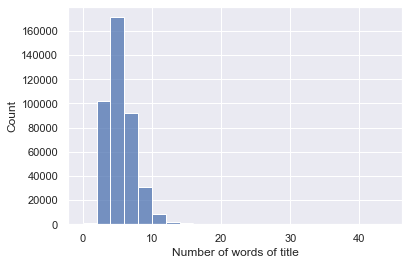

In [9]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=2)
fig.set_xlabel('Number of words of title')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

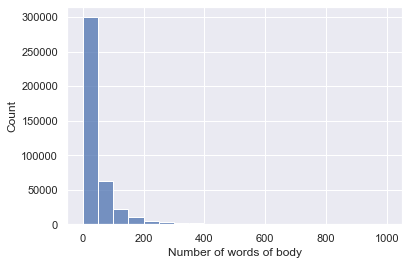

In [10]:
fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=50)
fig.set_xlabel('Number of words of body')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [11]:
df['number_of_words_of_body'].describe()

count    407799.000000
mean         45.938685
std          63.545595
min           0.000000
25%          12.000000
50%          24.000000
75%          52.000000
max         977.000000
Name: number_of_words_of_body, dtype: float64

In [12]:
# bugs == 0
# feature == 1
df['label'].value_counts()

1    207318
0    200481
Name: label, dtype: int64

## Load glove embeddings 100

In [13]:
glove2word2vec('glove.6B/glove.6B.100d.txt', 'tmpfile_glove')
glove_embeddings_model = KeyedVectors.load_word2vec_format('tmpfile_glove')

In [14]:
def get_word_glove_embedding(word):
    if word not in glove_embeddings_model:
        return np.zeros(100, dtype='float32')
    return glove_embeddings_model.get_vector(word)

In [15]:
def get_sentence_glove_embedding(sentence):
    word_embeddings = [glove_embeddings_model.get_vector(word) if word in glove_embeddings_model else np.zeros(100, dtype='float32') for word in sentence.split()]
    if len(word_embeddings) == 0:
        return np.zeros(100, dtype='float32')
    return np.mean(word_embeddings, axis=0)

## Train fasttext embeddings

In [16]:
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
np.savetxt('train.txt', train_input, fmt='%s')
np.savetxt('test.txt', test_input, fmt='%s')
fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
fasttext_model.test('test.txt')
df.drop('fasttext_input', axis=1, inplace=True)
embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

## Train baseline models

### GloVe + logistic regression classification

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
X_train = [get_sentence_glove_embedding(s) for s in X_train.values]
X_test = [get_sentence_glove_embedding(s) for s in X_test.values]

In [18]:
def run_logistic_regression_classifier(use_global_random_number=True):
    if use_global_random_number:
        random_state = global_random_number
    else:
        random_state = get_random_number()
    logit_clf = LogisticRegression(random_state=random_state, solver='liblinear').fit(X_train, y_train)
    predicted_labels = logit_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [19]:
logit_evaluation_results = []
logit_evaluation_results.append(run_logistic_regression_classifier())

(0.722695320046963, 0.7408314087759815, 0.7013935453776858)


### GloVe + knn

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
def run_knn_regression_classifier():
    knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    predicted_labels = knn_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [67]:
knn_evaluation_results = []
knn_evaluation_results.append(run_knn_regression_classifier())

(0.6918052521289402, 0.7341481519843942, 0.6199090405527535)


### Fasttext classification

In [20]:
_, test_df = train_test_split(df, test_size=0.33, random_state=42)
predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]
true_labels = test_df['label'].values
calculate_accuracy_precision_recall(true_labels, predicted_labels)

(0.7966471978242454, 0.813314895298301, 0.7801667589866185)

### MLP

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x_train, x_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
x_train = [get_sentence_glove_embedding(s) for s in x_train.values]
x_test = [get_sentence_glove_embedding(s) for s in x_test.values]

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.values).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.values).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

BATCH_SIZE = 255

# generate train dataset and train dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# generate test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

cuda


In [51]:
class MLP(torch.nn.Module):
    def __init__(self) : 
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(100 , 250)
        self.linear2 = torch.nn.Linear(250, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [57]:
def run_mlp_classifier():
    # Initialize the MLP
    mlp = MLP().to(device)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    mlp.train()
    # Run the training loop
    for epoch in range(0, 50):
        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dataloader):
            # Get inputs
            targets = targets.squeeze()

            # Perform forward pass
            outputs = mlp(inputs)
            outputs = outputs.squeeze()

            # Compute loss
            loss = loss_function(outputs, targets)


            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Zero the gradients
            optimizer.zero_grad()

        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')
    # Process is complete.
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    with torch.no_grad():
        mlp.eval()
        pred = mlp(test_dataset.tensors[0].to(device))
        y_true = test_dataset.tensors[1].tolist()
        y_pred = torch.round(torch.tensor(pred.tolist()).squeeze())
        results = calculate_accuracy_precision_recall(y_true, y_pred)

    print(results)
    return results

In [58]:
mlp_evaluation_results = []
mlp_evaluation_results.append(run_mlp_classifier())

Epoch: 0, Epoch loss 0.5467864274978638
Epoch: 1, Epoch loss 0.5287327170372009
Epoch: 2, Epoch loss 0.5218595862388611
Epoch: 3, Epoch loss 0.5106785297393799
Epoch: 4, Epoch loss 0.5000659823417664
Epoch: 5, Epoch loss 0.5005460381507874
Epoch: 6, Epoch loss 0.48574137687683105
Epoch: 7, Epoch loss 0.4874698519706726
Epoch: 8, Epoch loss 0.47833412885665894
Epoch: 9, Epoch loss 0.4708586633205414
Training process has finished.
Final loss 0.4708586633205414
(0.7306686284126206, 0.7485596644594325, 0.7102271070814262)


## Train our model

In [25]:
def create_graph_of_words(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = embeddings_lookup.get(word, np.zeros(100, dtype='float32'))
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch(text, window_size):
    return from_networkx(create_graph_of_words(text, window_size))

def generate_pytorch_geometric_graphs(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [26]:
pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=7)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [18:09<00:00, 374.45it/s]


finished...


In [27]:
train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

In [28]:
def run_gat_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs, batch_size=200, shuffle=False)
    
    gat_model = GATClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [29]:
gat_evaluation_results = []
gat_evaluation_results.append(run_gat_classifier())

GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.34798863530158997
Epoch: 1, Epoch loss 0.3490433990955353
Epoch: 2, Epoch loss 0.34401196241378784
Epoch: 3, Epoch loss 0.338461697101593
Epoch: 4, Epoch loss 0.330524742603302
Epoch: 5, Epoch loss 0.3304673731327057
Epoch: 6, Epoch loss 0.32263198494911194
Epoch: 7, Epoch loss 0.31862515211105347
Epoch: 8, Epoch loss 0.32849597930908203
Epoch: 9, Epoch loss 0.3328363001346588
Training process has finished.
Final loss 0.3328363001346588
(0.8025250048300563, 0.8109618356913566, 0.797509609341888)


### Glove + GATConv

In [30]:
def create_graph_of_words_glove(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = get_word_glove_embedding(word)
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [31]:
pytorch_geometric_graphs_glove = generate_pytorch_geometric_graphs_glove(window_size=7)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [17:37<00:00, 385.50it/s]


finished...


In [32]:
train_pyg_graphs_glove, test_pyg_graphs_glove = train_test_split(pytorch_geometric_graphs_glove, test_size=0.33, random_state=42)

In [33]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [34]:
gat_glove_evaluation_results = []
gat_glove_evaluation_results.append(run_gat_glove_classifier())

GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5432955622673035
Epoch: 1, Epoch loss 0.5186551809310913
Epoch: 2, Epoch loss 0.49953871965408325
Epoch: 3, Epoch loss 0.5260472297668457
Epoch: 4, Epoch loss 0.4987495541572571
Epoch: 5, Epoch loss 0.5135094523429871
Epoch: 6, Epoch loss 0.4957980215549469
Epoch: 7, Epoch loss 0.5137096643447876
Epoch: 8, Epoch loss 0.5037187933921814
Epoch: 9, Epoch loss 0.5215823650360107
Training process has finished.
Final loss 0.5215823650360107
(0.7637359371052358, 0.7733188072709907, 0.7573038305832834)


### Glove + GCNonv

In [35]:
class GCNGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GCNConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [36]:
def run_gcn_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GCNGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [37]:
gcn_glove_evaluation_results = []
gcn_glove_evaluation_results.append(run_gcn_glove_classifier())

GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5705499053001404
Epoch: 1, Epoch loss 0.5697073340415955
Epoch: 2, Epoch loss 0.5562869310379028
Epoch: 3, Epoch loss 0.5690243244171143
Epoch: 4, Epoch loss 0.5552098155021667
Epoch: 5, Epoch loss 0.5686145424842834
Epoch: 6, Epoch loss 0.5702721476554871
Epoch: 7, Epoch loss 0.5903779864311218
Epoch: 8, Epoch loss 0.5587636828422546
Epoch: 9, Epoch loss 0.5603534579277039
Training process has finished.
Final loss 0.5603534579277039
(0.7294053829120039, 0.7465643680285943, 0.7082121508849364)


### Glove + GraphConv

In [38]:
class GraphConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GraphConv(100, 10, aggr='mean')
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [39]:
def run_graphconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GraphConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [40]:
graphconv_glove_evaluation_results = []
graphconv_glove_evaluation_results.append(run_graphconv_glove_classifier())

GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.556878924369812
Epoch: 1, Epoch loss 0.5519242286682129
Epoch: 2, Epoch loss 0.5434998273849487
Epoch: 3, Epoch loss 0.5496436953544617
Epoch: 4, Epoch loss 0.546381950378418
Epoch: 5, Epoch loss 0.5566105246543884
Epoch: 6, Epoch loss 0.5527468919754028
Epoch: 7, Epoch loss 0.5617696046829224
Epoch: 8, Epoch loss 0.531860888004303
Epoch: 9, Epoch loss 0.5340650081634521
Training process has finished.
Final loss 0.5340650081634521
(0.7483986505565711, 0.7600595900923948, 0.7381874515879163)


### Glove + SAGEConv

In [47]:
class SAGEConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        
        self.conv1 = SAGEConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [48]:
def run_sageconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = SAGEConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [50]:
sageconv_glove_evaluation_results = []
sageconv_glove_evaluation_results.append(run_sageconv_glove_classifier(num_epoch))

SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5568789839744568
Epoch: 1, Epoch loss 0.5519242286682129
Epoch: 2, Epoch loss 0.5434998273849487
Epoch: 3, Epoch loss 0.5496436953544617
Epoch: 4, Epoch loss 0.546381950378418
Epoch: 5, Epoch loss 0.5566105246543884
Epoch: 6, Epoch loss 0.5527468919754028
Epoch: 7, Epoch loss 0.5617696046829224
Epoch: 8, Epoch loss 0.5318608283996582
Epoch: 9, Epoch loss 0.5340650081634521
Epoch: 10, Epoch loss 0.5269910097122192
Epoch: 11, Epoch loss 0.5415917634963989
Epoch: 12, Epoch loss 0.5225735902786255
Epoch: 13, Epoch loss 0.5119897723197937
Epoch: 14, Epoch loss 0.5248987674713135
Epoch: 15, Epoch loss 0.5316376686096191
Epoch: 16, Epoch loss 0.5322040915489197
Epoch: 17, Epoch loss 0.5357478857040405
Epoch: 18, Epoch loss 0.541910707950592
Epoch: 19, Epoch loss 0.5312440395355225
Epoch: 20, Epoch loss 0.5123745203018188
Epoch: 21

## Parameter Sensitivity